In [1]:
import pandas as pd
import numpy as np

In [17]:
kospi = pd.read_csv('kospi(18~22).csv')
corps_code = kospi['종목코드'].unique().tolist()
corps_name = kospi['회사명'].unique().tolist()
corps = pd.DataFrame({'corp_code':corps_code, 'corp_name':corps_name})
corps

,corp_code,corp_name
0,990,DB하이텍
1,97230,HJ중공업
2,23150,MH에탄올
3,2360,SH에너지화학
4,9160,SIMPAC
...,...,...
668,298040,효성중공업
669,298050,효성첨단소재
670,298020,효성티앤씨
671,298000,효성화학


In [15]:
corps['corp_code'] = corps['corp_code'].astype(str).str.zfill(6)
corps['corp_name'] = [name.replace('(주)', '') for name in corps['corp_name']]
corps

,corp_code,corp_name
0,000990,DB하이텍
1,097230,HJ중공업
2,023150,MH에탄올
3,002360,SH에너지화학
4,009160,SIMPAC
...,...,...
668,298040,효성중공업
669,298050,효성첨단소재
670,298020,효성티앤씨
671,298000,효성화학


In [16]:
from dateutil.relativedelta import relativedelta
import requests as rq
from io import BytesIO
from datetime import date


adjust_price = pd.DataFrame(columns=['날짜', '종목', '종목코드', '종가'])

for i in range(len(corps.index)):#179개 종목을 모두 불러냄

    ticker = corps['corp_code'][i]
    name = corps['corp_name'][i]
    # fr = ("20131230").strptime("%Y%m%d")
    # to = ("20221230").strptime("%Y%m%d")

    url = f'''https://fchart.stock.naver.com/siseJson.nhn?symbol={ticker}&requestType=1
    &startTime=20130101&endTime=20231231&timeframe=day'''

    data = rq.get(url).content
    data_price = pd.read_csv(BytesIO(data))


    price = data_price.iloc[:, 0:6]
    price.columns = ['날짜', '시가', '고가', '저가', '종가', '거래량']
    price = price.dropna()
    price['날짜'] = price['날짜'].str.extract('(\d+)')
    price['날짜'] = pd.to_datetime(price['날짜'])
    price['종목코드'] = ticker
    price['종목'] = name


    #날짜, 종목, 종목코드, 종가, 시가, 고가, 저가, 거래량에서 원하는 컬럼만 남기기.
    columns_to_keep = ['날짜', '종목', '종목코드', '종가']
    price = price[columns_to_keep]


    #4월만 추출
    price = price[price['날짜'].dt.month == 4]
    #첫 날만 추출
    price = price.sort_values('날짜').groupby(price['날짜'].dt.year).first()

    adjust_price = pd.concat([adjust_price, price], ignore_index=True)

adjust_price


KeyboardInterrupt: 

In [5]:
adjust_price['수익률'] = adjust_price.groupby('종목')['종가'].pct_change()
adjust_price

,날짜,종목,종목코드,종가,수익률
0,2013-04-01,DB하이텍,000990,6440.0,NaN
1,2014-04-01,DB하이텍,000990,6640.0,0.031056
2,2015-04-01,DB하이텍,000990,5880.0,-0.114458
3,2016-04-01,DB하이텍,000990,18100.0,2.078231
4,2017-04-03,DB하이텍,000990,20350.0,0.124309
...,...,...,...,...,...
7465,2019-04-01,흥아해운,003280,3523.0,-0.564739
7466,2020-04-01,흥아해운,003280,1555.0,-0.558615
7467,2021-04-01,흥아해운,003280,1555.0,0.000000
7468,2022-04-01,흥아해운,003280,2850.0,0.832797


In [6]:
adjust_price.to_csv("./adjust_price.csv")

In [18]:
kospi['전년 수익률'] = kospi['수익률'].shift()
kospi.head(15)

,회사명,종목코드,회계년도,종가,ROE,시가총액,PER,PBR,PCR,PSR,PRR,RDS,RDO,RDN,ROA,판관비,EY,수정종가,수익률,전년 수익률
0,DB하이텍,990,2018,10850.0,1.051202,4.817247e+11,-0.420016,-0.102793,-0.330934,-0.332123,-0.187528,3.129084,0.452043,0.267248,0.915791,-0.359154,1.593415,14150.0,-3.046683,NaN
1,DB하이텍,990,2019,27600.0,1.084892,1.225401e+12,-0.420889,-0.059488,-0.308201,-0.325966,-0.185292,2.655557,0.191781,0.205179,1.269900,-0.598965,0.785723,13000.0,-0.812721,-3.046683
2,DB하이텍,990,2020,51000.0,1.767110,2.264328e+12,-0.399472,0.296942,-0.316410,-0.254813,-0.182456,2.384364,0.094742,0.068176,2.349707,-0.677220,0.383688,20900.0,6.076923,-0.812721
3,DB하이텍,990,2021,72700.0,3.004007,3.227777e+12,-0.399414,0.766631,-0.281540,-0.152189,-0.180473,1.946054,-0.039200,-0.048378,3.883192,-0.698407,0.605251,57700.0,17.607656,6.076923
4,DB하이텍,990,2022,37150.0,3.891974,1.649408e+12,-0.448185,0.130386,-0.332056,-0.254129,-0.185392,1.617175,-0.137729,-0.099635,4.275733,-0.583749,4.321560,73400.0,2.720971,17.607656
5,HJ중공업,97230,2020,7320.0,2.325398,6.095677e+11,-0.416292,0.197008,-0.351631,-0.425854,-0.137698,-0.401981,-0.233989,-0.185900,-0.186364,-0.524728,-0.515220,4390.0,-6.700984,2.720971
6,MH에탄올,23150,2018,5890.0,-1.120586,4.345952e+10,-0.429037,-0.579144,-0.294871,-0.349228,-0.189092,-0.456484,-0.297140,-0.206105,-1.706915,0.044697,0.237546,6580.0,-1.574904,-6.700984
7,MH에탄올,23150,2020,8410.0,0.373797,6.205340e+10,0.225769,-0.129442,-0.250459,-0.278759,-0.189092,-0.456484,-0.297140,-0.206105,-0.843665,-0.171148,-0.058830,8050.0,2.160121,-1.574904
8,MH에탄올,23150,2021,10200.0,0.136765,7.526097e+10,-0.268348,0.203671,0.307323,-0.174082,-0.189092,-0.456484,-0.297140,-0.206105,-0.583459,-0.239215,-0.576930,8540.0,0.608696,2.160121
9,MH에탄올,23150,2022,7610.0,-0.081015,5.615058e+10,-0.346801,-0.156091,-0.383625,-0.267812,-0.189092,-0.456484,-0.297140,-0.206105,-0.405894,-0.025420,-0.827798,10000.0,1.709602,0.608696


In [19]:
kospi = kospi.dropna()
kospi.head(15)

,회사명,종목코드,회계년도,종가,ROE,시가총액,PER,PBR,PCR,PSR,PRR,RDS,RDO,RDN,ROA,판관비,EY,수정종가,수익률,전년 수익률
1,DB하이텍,990,2019,27600.0,1.084892,1.225401e+12,-0.420889,-0.059488,-0.308201,-0.325966,-0.185292,2.655557,0.191781,0.205179,1.269900,-0.598965,0.785723,13000.0,-0.812721,-3.046683
2,DB하이텍,990,2020,51000.0,1.767110,2.264328e+12,-0.399472,0.296942,-0.316410,-0.254813,-0.182456,2.384364,0.094742,0.068176,2.349707,-0.677220,0.383688,20900.0,6.076923,-0.812721
3,DB하이텍,990,2021,72700.0,3.004007,3.227777e+12,-0.399414,0.766631,-0.281540,-0.152189,-0.180473,1.946054,-0.039200,-0.048378,3.883192,-0.698407,0.605251,57700.0,17.607656,6.076923
4,DB하이텍,990,2022,37150.0,3.891974,1.649408e+12,-0.448185,0.130386,-0.332056,-0.254129,-0.185392,1.617175,-0.137729,-0.099635,4.275733,-0.583749,4.321560,73400.0,2.720971,17.607656
5,HJ중공업,97230,2020,7320.0,2.325398,6.095677e+11,-0.416292,0.197008,-0.351631,-0.425854,-0.137698,-0.401981,-0.233989,-0.185900,-0.186364,-0.524728,-0.515220,4390.0,-6.700984,2.720971
6,MH에탄올,23150,2018,5890.0,-1.120586,4.345952e+10,-0.429037,-0.579144,-0.294871,-0.349228,-0.189092,-0.456484,-0.297140,-0.206105,-1.706915,0.044697,0.237546,6580.0,-1.574904,-6.700984
7,MH에탄올,23150,2020,8410.0,0.373797,6.205340e+10,0.225769,-0.129442,-0.250459,-0.278759,-0.189092,-0.456484,-0.297140,-0.206105,-0.843665,-0.171148,-0.058830,8050.0,2.160121,-1.574904
8,MH에탄올,23150,2021,10200.0,0.136765,7.526097e+10,-0.268348,0.203671,0.307323,-0.174082,-0.189092,-0.456484,-0.297140,-0.206105,-0.583459,-0.239215,-0.576930,8540.0,0.608696,2.160121
9,MH에탄올,23150,2022,7610.0,-0.081015,5.615058e+10,-0.346801,-0.156091,-0.383625,-0.267812,-0.189092,-0.456484,-0.297140,-0.206105,-0.405894,-0.025420,-0.827798,10000.0,1.709602,0.608696
10,SH에너지화학,2360,2018,1100.0,-0.742779,1.222471e+11,0.121941,-0.022846,0.103575,-0.359490,-0.189092,-0.456484,-0.297140,-0.206105,-0.647048,-0.616699,-0.556075,1430.0,-0.920635,1.709602


In [20]:
# 날짜를 년도로 변환
kospi['날짜'] = pd.to_datetime(kospi['날짜'])
kospi['년도'] = kospi['날짜'].dt.year
adjust_price

,날짜,종목,종목코드,종가,년도
0,2013-04-01,DB하이텍,000990,6440.0,2013
1,2014-04-01,DB하이텍,000990,6640.0,2014
2,2015-04-01,DB하이텍,000990,5880.0,2015
3,2016-04-01,DB하이텍,000990,18100.0,2016
4,2017-04-03,DB하이텍,000990,20350.0,2017
...,...,...,...,...,...
6362,2019-04-01,한국앤컴퍼니,000240,15900.0,2019
6363,2020-04-01,한국앤컴퍼니,000240,8600.0,2020
6364,2021-04-01,한국앤컴퍼니,000240,18200.0,2021
6365,2022-04-01,한국앤컴퍼니,000240,14500.0,2022


In [21]:
momentum_list = [pd.DataFrame() for _ in range(5)]

for i, (year, group_df) in enumerate(kospi.groupby('회계년도')):
    sorted_df = group_df.sort_values('전년 수익률', ascending=False)
    momentum_list[i] = sorted_df  # sorted_df를 momentum_list에 추가
    print(f"---- {year} ----")
    print(sorted_df)

---- 2018 ----
        회사명    종목코드  회계년도        종가       ROE          시가총액       PER   
1541  삼성SDI    6400  2018  219000.0 -0.280748  1.505943e+13 -0.167778  \
1747    씨제이    1040  2018  121500.0 -0.177272  3.545005e+12  1.019674   
921    하나투어   39130  2018   68800.0 -0.488903  7.991935e+11  0.424115   
2000   일성신약    3120  2018   95600.0 -0.899196  2.542960e+11  0.689622   
665     유니켐   11330  2018    1495.0  1.770720  8.913257e+10 -0.388589   
...     ...     ...   ...       ...       ...           ...       ...   
544   엔씨소프트   36570  2018  466500.0  0.969384  1.023455e+13 -0.257290   
891     퍼시스   16800  2018   30700.0  0.350936  3.530500e+11 -0.411112   
191     덴티움  145720  2018   57500.0  1.307485  6.364577e+11 -0.228364   
6     MH에탄올   23150  2018    5890.0 -1.120586  4.345952e+10 -0.429037   
1466   명문제약   17180  2018    5190.0 -0.882351  1.273626e+11  1.803335   

           PBR       PCR       PSR       PRR       RDS       RDO       RDN   
1541 -0.042833 -0.383625 -0.21

In [22]:
return_mean = [pd.DataFrame() for _ in range(5)]

for i in range(5):
    momentum_list[i]['quantile'] = pd.qcut(momentum_list[i]['전년 수익률'], 5, labels=False)
    quantile_means = momentum_list[i].groupby('quantile')['수익률'].mean()
    return_mean[i] = quantile_means
    print(quantile_means)

quantile
0    1.183639
1    0.724485
2    1.024601
3    0.637620
4    1.288007
Name: 수익률, dtype: float64
quantile
0   -0.446666
1   -0.243546
2   -0.164529
3   -0.905796
4   -0.039299
Name: 수익률, dtype: float64
quantile
0   -2.789640
1   -2.774465
2   -2.545172
3   -2.864268
4   -3.388745
Name: 수익률, dtype: float64
quantile
0    11.612510
1     8.765613
2    10.109427
3     9.170952
4    10.768923
Name: 수익률, dtype: float64
quantile
0    0.221530
1    1.285226
2    1.108162
3    0.489819
4    1.001106
Name: 수익률, dtype: float64


In [24]:
re = pd.concat([return_mean[0],return_mean[1],return_mean[2],return_mean[3]], axis=1)
re.columns = ['2019', '2020', '2021', '2022']
re


,2019,2020,2021,2022
quantile,,,,
0,1.183639,-0.446666,-2.789640,11.612510
1,0.724485,-0.243546,-2.774465,8.765613
2,1.024601,-0.164529,-2.545172,10.109427
3,0.637620,-0.905796,-2.864268,9.170952
4,1.288007,-0.039299,-3.388745,10.768923


In [25]:
re.mean(axis=1)

quantile
0    2.389961
1    1.618022
2    2.106082
3    1.509627
4    2.157221
dtype: float64

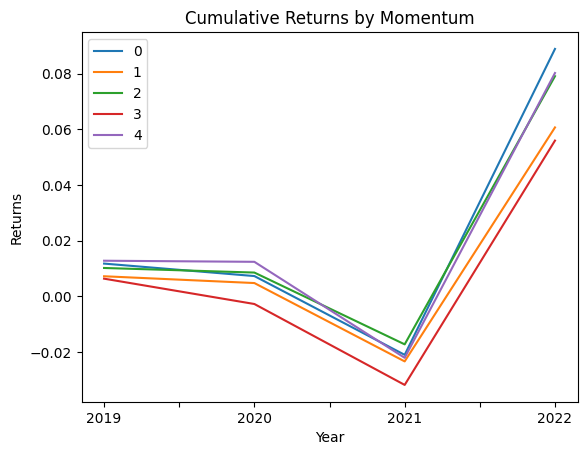

In [26]:
import matplotlib.pyplot as plt
# 누적 수익률 계산
re_tran = re.transpose()  # Assume that these are returns
re_tran

re_tran = np.log(1+re_tran/100).cumsum()

# 그래프 그리기
re_tran.plot()
plt.xlabel('Year')
plt.ylabel('Returns')
plt.title('Cumulative Returns by Momentum')
plt.legend(title='')
plt.show()